# Проект: Аналитика для маркетинговых кампаний банка

## Описание проекта

Датасет содержит информацию о клиентах португальского банковского учреждения для прямых маркетинговых кампаний.

**Цель исследования:**

Предсказать, оформит ли клиент срочный депозит (признак в столбце `deposit`).

**Описание данных:**

Данные содержатся в файле `bank.csv`.

Признаки:
- `age`	- возраст
- `job`	- должность
- `marital` - семейное положение
- `education` - уровень образований
- `default` - наличие просроченной задолженности по кредиту
- `balance` - средний годовой баланс
- `housing` - наличие жилищного кредита
- `loan` - наличие потребительского кредита
- `contact` - тип контактной связи
- `day` - последний контактный день
- `month` - последний контактный месяц года
- `duration` - длительность последнего контакта в секундах (числовое значение). Важное примечание: этот атрибут сильно влияет на выходную цель (например, если длительность = 0, то y = «нет»). Однако длительность неизвестна до выполнения вызова. Кроме того, после окончания вызова y, очевидно, известен. Таким образом, эту переменную следует включать только для целей сравнительного анализа и отбрасывать для построения модели реалистичного предсказания.
- `campaign` - количество контактов, выполненных в ходе этой кампании и для этого клиента
- `pdays` - количество дней, прошедших с момента последнего контакта с клиентом в рамках предыдущей кампании (-1 означает, что с клиентом ранее не связывались)
- `previous` - количество контактов, выполненных до этой кампании и для этого клиента
- `poutcome` - результат предыдущей маркетинговой кампании
- **`deposit` - оформит ли клиент срочный депозит (целевой признак)**


Источник данных: https://archive.ics.uci.edu/dataset/222/bank+marketing


**Ход исследования:**

1. Загрузка и обзор данных.
2. Исследовательский анализ и предобработка данных.
3. Обучение моделей. Подготовим выборки для обучения моделей, для каждой модели попробуем разные гиперпараметры. Для оценки качества моделей будем применять метрику ROC-AUC.
4. Тестирование лучшей модели.
5. Выводы.

## Загрузка и обзор данных

Импортируем библиотеки.

In [1]:
#установим библиотеки
!pip install scikit-learn==1.4.0
!pip install phik -q
!pip install catboost
!pip install lightgbm

import pandas as pd 
import numpy as np
from scipy import stats as st
import time
from time import time

#библиотеки для построения графиков
import seaborn as sns
import matplotlib.pyplot as plt
import phik
sns.set()

#класс для разделения на выборки
from sklearn.model_selection import train_test_split 

#загружаем классы для подготовки данных
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures, OrdinalEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder
from sklearn.compose import ColumnTransformer

#загружаем класс pipeline
from sklearn.pipeline import Pipeline

#загружаем функцию для работы с метриками
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

#импортируем класс RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV

#модели
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.neighbors import KNeighborsClassifier

import warnings
warnings.filterwarnings("ignore")

#константы
RANDOM_STATE = 42
TEST_SIZE = 0.25

Считаем CSV-файл с данными с помощью библиотеки pandas и сохраним его в датафрейм.

In [2]:
data = pd.read_csv('/Users/margarita/Desktop/datasets/bank.csv')

Изучим общую информацию о данных.

In [3]:
data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes


In [4]:
data.shape

(11162, 17)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11162 non-null  int64 
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(7), object(10)
memory usage: 1.4+ MB


In [6]:
print('Проверка на наличие пропусков')
data.isna().sum()

Проверка на наличие пропусков


age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
deposit      0
dtype: int64

In [7]:
print('Проверка на наличие явных дубликатов')
data.duplicated().sum()

Проверка на наличие явных дубликатов


0

In [8]:
#вывод уникальных значений в каждом столбце
for column in data.columns:
    print(column, '\n', data[column].unique(), '\n')

age 
 [59 56 41 55 54 42 60 37 28 38 30 29 46 31 35 32 49 43 26 40 33 23 48 45
 36 52 53 39 57 51 44 24 50 27 34 47 25 58 61 68 75 22 69 66 85 72 90 67
 71 21 74 65 62 83 70 76 77 19 73 63 20 78 95 64 79 82 18 86 84 87 92 81
 80 93 88 89] 

job 
 ['admin.' 'technician' 'services' 'management' 'retired' 'blue-collar'
 'unemployed' 'entrepreneur' 'housemaid' 'unknown' 'self-employed'
 'student'] 

marital 
 ['married' 'single' 'divorced'] 

education 
 ['secondary' 'tertiary' 'primary' 'unknown'] 

default 
 ['no' 'yes'] 

balance 
 [2343   45 1270 ... 1594 2593 -134] 

housing 
 ['yes' 'no'] 

loan 
 ['no' 'yes'] 

contact 
 ['unknown' 'cellular' 'telephone'] 

day 
 [ 5  6  7  8  9 12 13 14 15 16 19 20 21 23 26 27 28 29 30  2  3  4 11 17
 18 24  1 10 22 25 31] 

month 
 ['may' 'jun' 'jul' 'aug' 'oct' 'nov' 'dec' 'jan' 'feb' 'mar' 'apr' 'sep'] 

duration 
 [1042 1467 1389 ... 1504  818 1812] 

campaign 
 [ 1  2  3  4  6  5  8 11  9 10 15 12 14  7 24 13 17 29 21 20 16 32 19 25
 22 43 18 

## Исследовательский анализ и предобработка данных

### Анализ количественных переменных

In [9]:
#вывод описательных статистик
data.describe()

,age,balance,day,duration,campaign,pdays,previous
count,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000
mean,41.231948,1528.538524,15.658036,371.993818,2.508421,51.330407,0.832557
std,11.913369,3225.413326,8.420740,347.128386,2.722077,108.758282,2.292007
min,18.000000,-6847.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,122.000000,8.000000,138.000000,1.000000,-1.000000,0.000000
50%,39.000000,550.000000,15.000000,255.000000,2.000000,-1.000000,0.000000
75%,49.000000,1708.000000,22.000000,496.000000,3.000000,20.750000,1.000000
max,95.000000,81204.000000,31.000000,3881.000000,63.000000,854.000000,58.000000


In [10]:
data.query('deposit=="yes"').describe()

,age,balance,day,duration,campaign,pdays,previous
count,5289.000000,5289.000000,5289.000000,5289.000000,5289.000000,5289.000000,5289.000000
mean,41.670070,1804.267915,15.158253,537.294574,2.141047,68.702968,1.170354
std,13.497781,3501.104777,8.501875,392.525262,1.921826,118.822266,2.553272
min,18.000000,-3058.000000,1.000000,8.000000,1.000000,-1.000000,0.000000
25%,31.000000,210.000000,8.000000,244.000000,1.000000,-1.000000,0.000000
50%,38.000000,733.000000,15.000000,426.000000,2.000000,-1.000000,0.000000
75%,50.000000,2159.000000,22.000000,725.000000,3.000000,98.000000,1.000000
max,95.000000,81204.000000,31.000000,3881.000000,32.000000,854.000000,58.000000


In [11]:
data.query('deposit=="no"').describe()

,age,balance,day,duration,campaign,pdays,previous
count,5873.000000,5873.000000,5873.000000,5873.000000,5873.000000,5873.000000,5873.00000
mean,40.837391,1280.227141,16.108122,223.130257,2.839264,35.685340,0.52835
std,10.264815,2933.411934,8.322071,208.577530,3.244474,96.182893,1.97961
min,18.000000,-6847.000000,1.000000,2.000000,1.000000,-1.000000,0.00000
25%,33.000000,64.000000,9.000000,94.000000,1.000000,-1.000000,0.00000
50%,39.000000,414.000000,16.000000,163.000000,2.000000,-1.000000,0.00000
75%,48.000000,1324.000000,22.000000,282.000000,3.000000,-1.000000,0.00000
max,89.000000,66653.000000,31.000000,3284.000000,63.000000,826.000000,41.00000


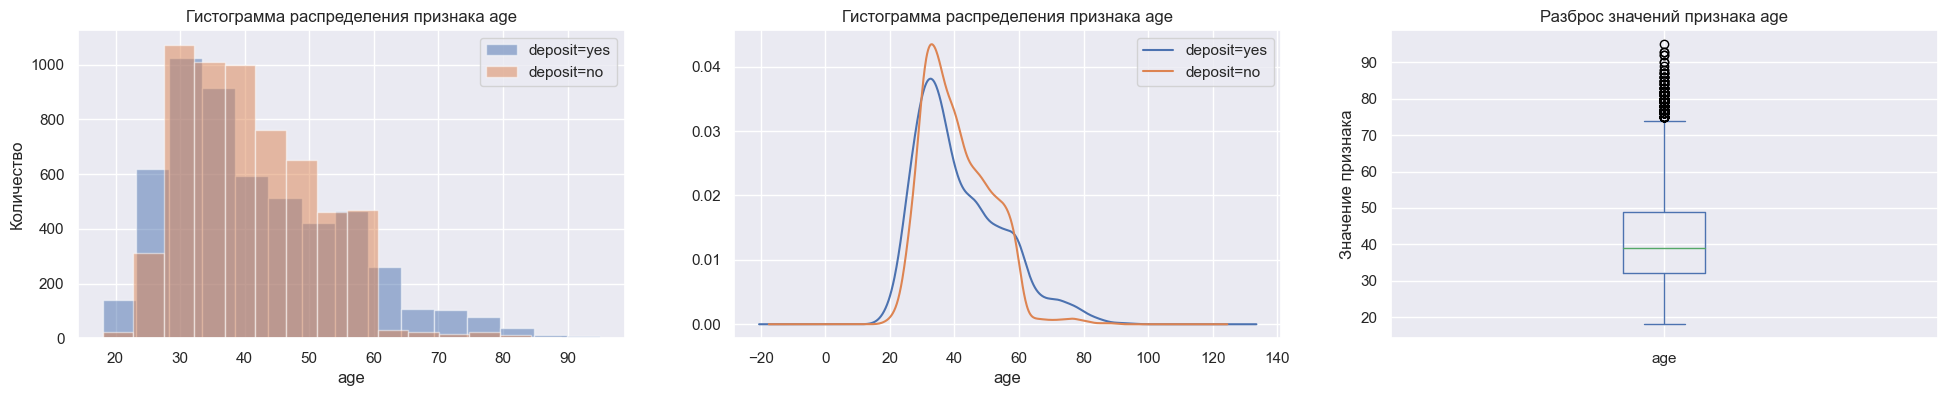

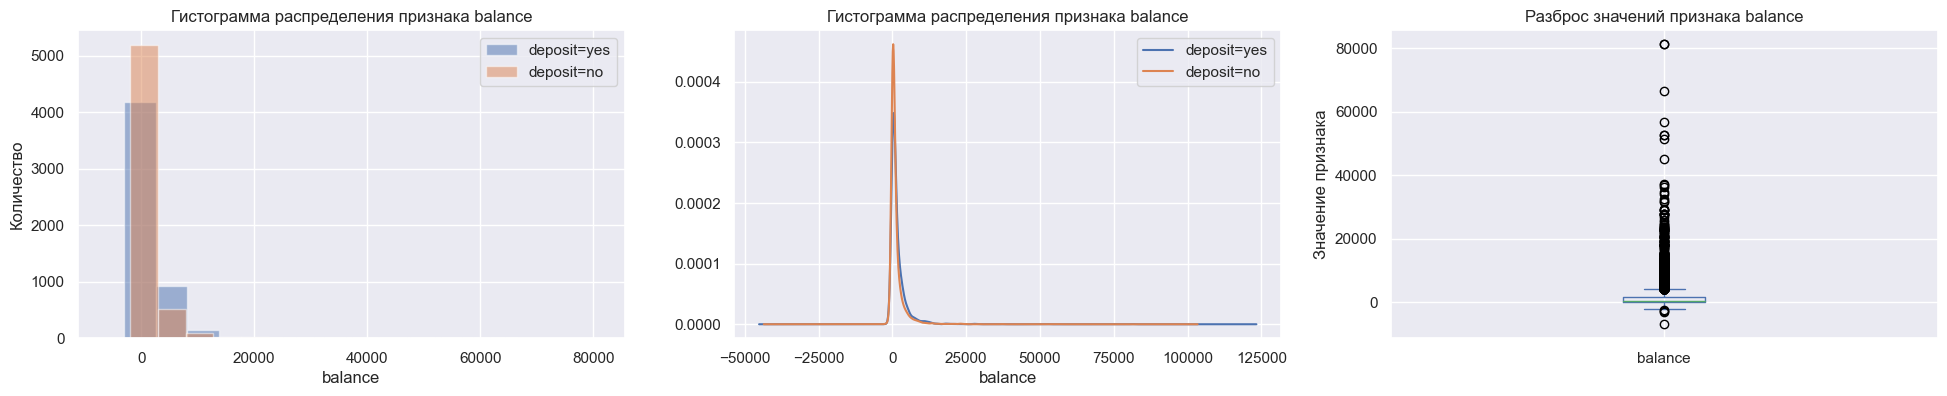

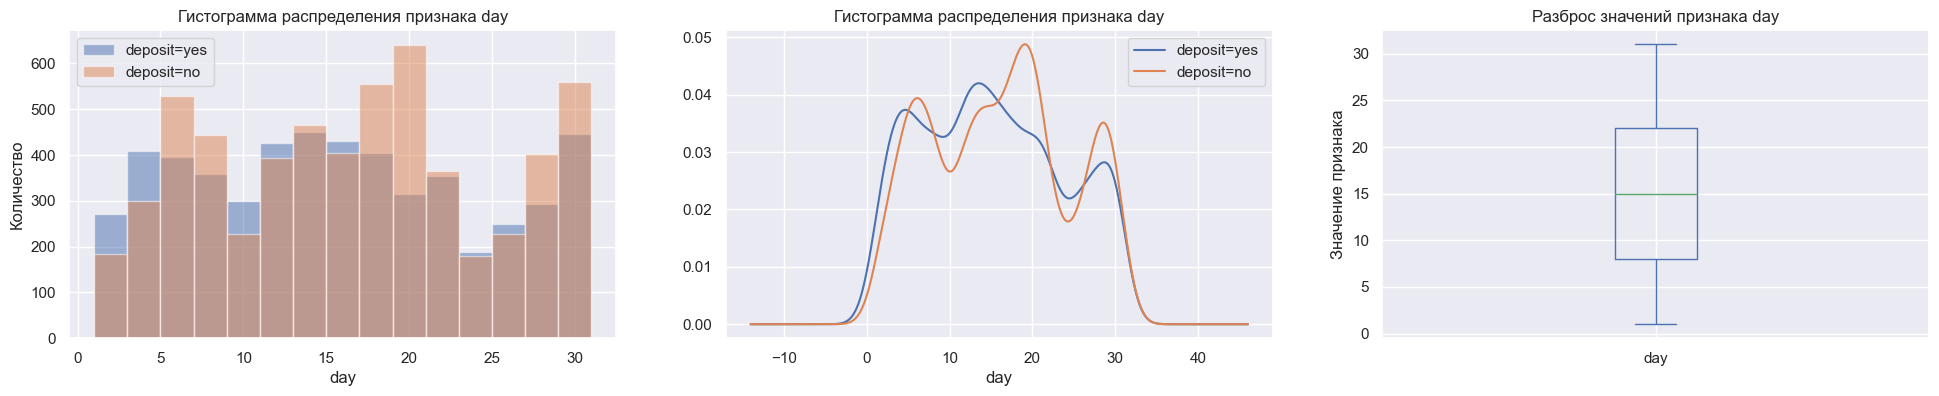

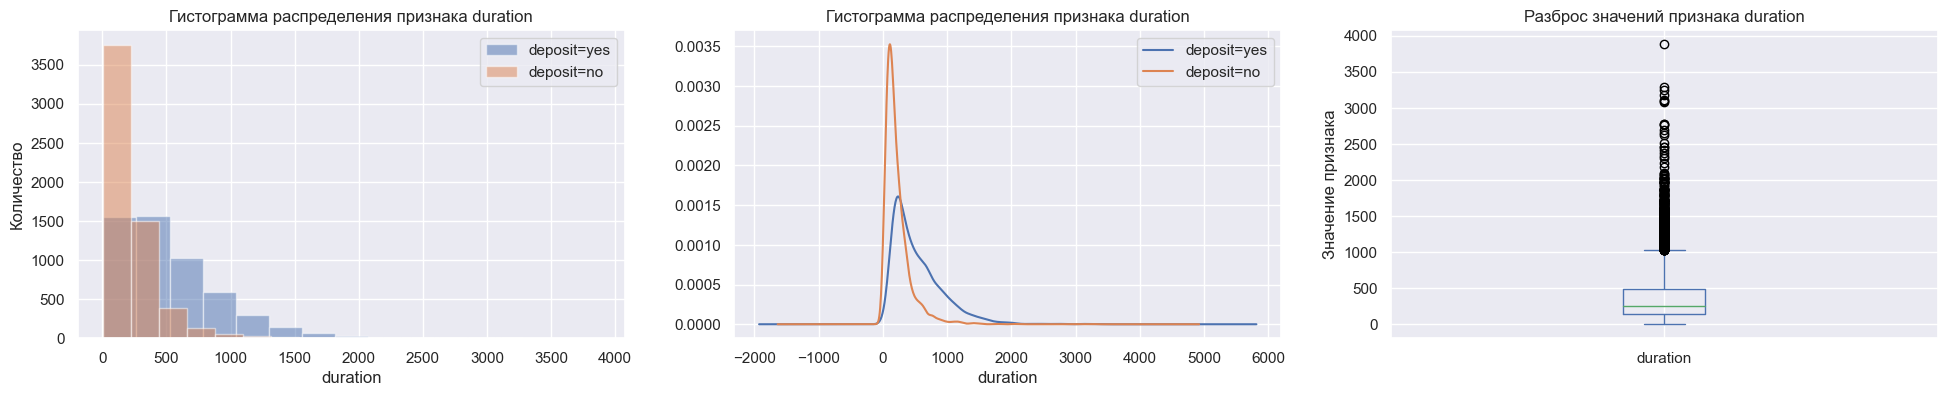

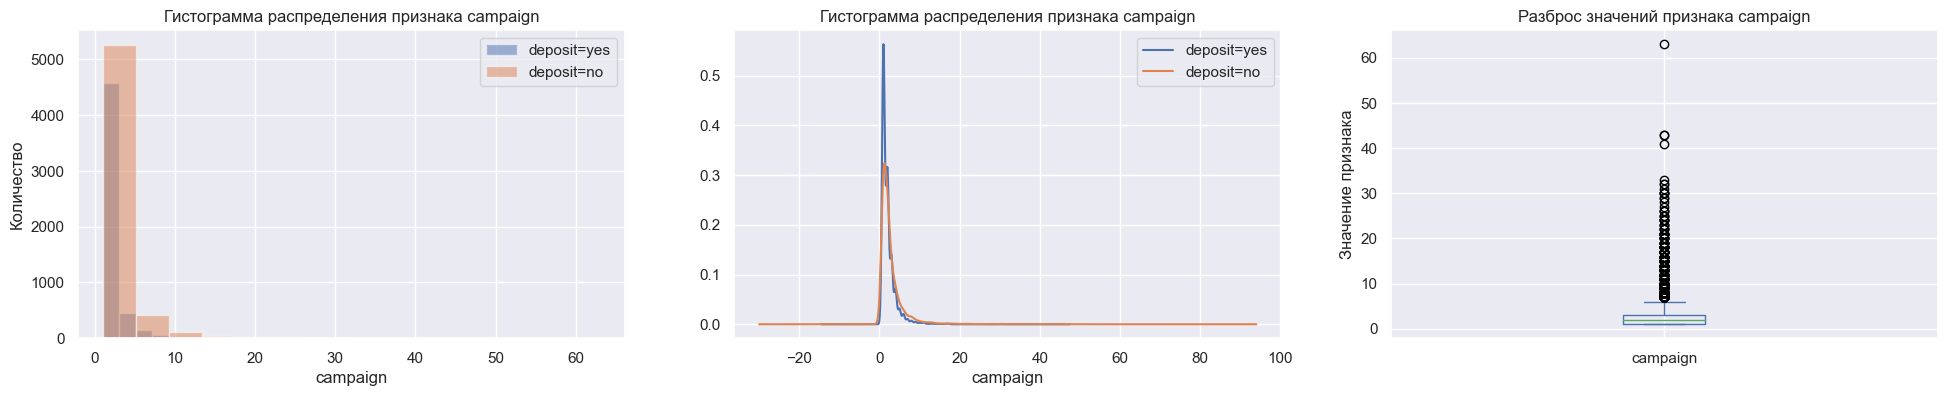

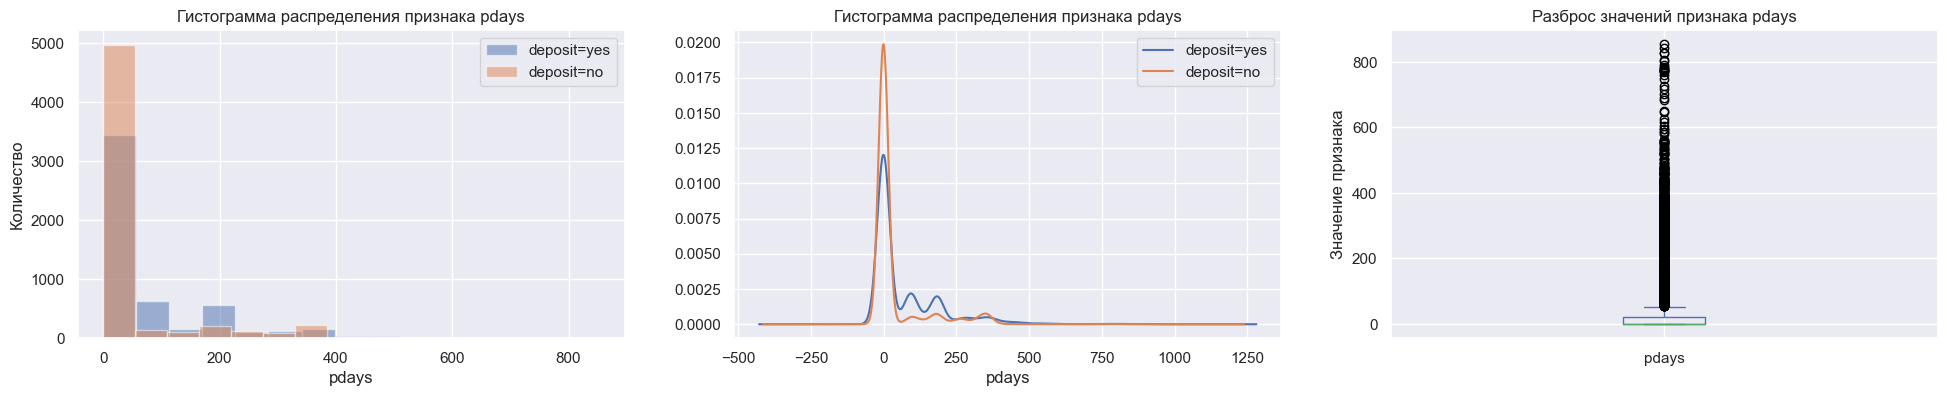

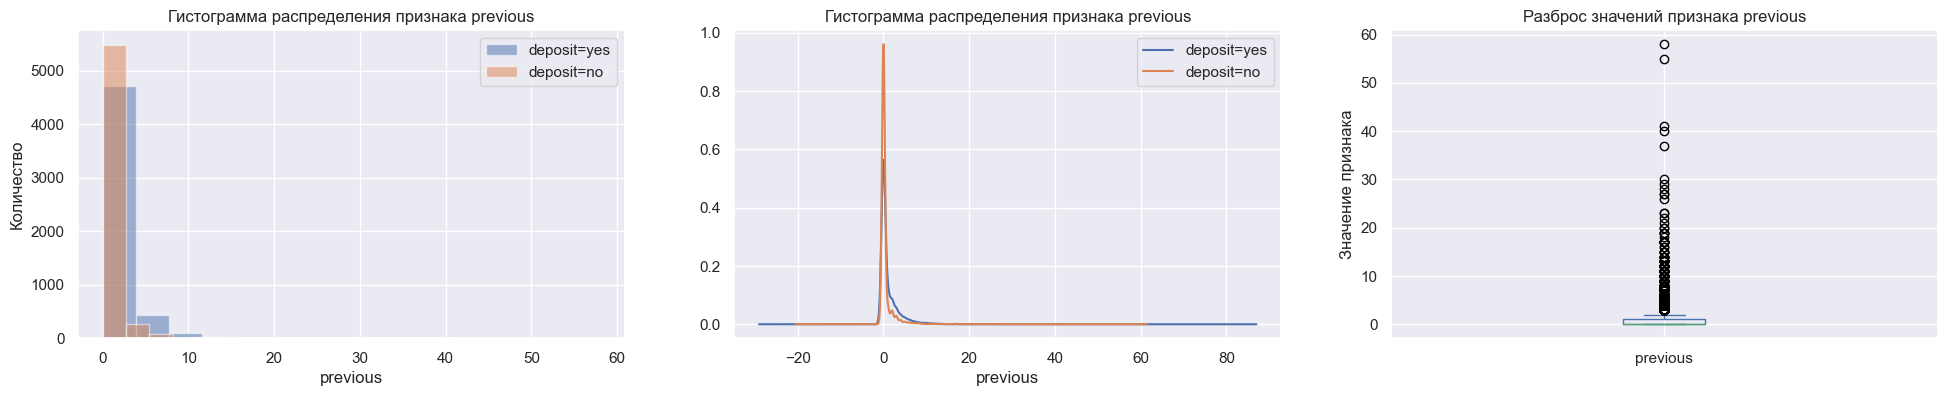

In [12]:
col_names = data.select_dtypes(include='number').columns

for col in col_names:
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(24,4))
    
    axes[0] = data.query('deposit=="yes"')[col].plot(kind='hist', bins=15, ax=axes[0], alpha=0.5)
    data.query('deposit=="no"')[col].plot(kind='hist', bins=15, ax=axes[0], 
                                          color=sns.color_palette().as_hex()[1], alpha=0.5) 

    axes[0].set_title(f'Гистограмма распределения признака {col}')
    axes[0].set_xlabel(f'{col}')
    axes[0].set_ylabel('Количество')
    axes[0].legend(['deposit=yes', 'deposit=no'])
    
    axes[1] = data.query('deposit=="yes"')[col].plot(kind='kde', ax=axes[1])
    data.query('deposit=="no"')[col].plot(kind='kde', ax=axes[1])
    axes[1].set_title(f'Гистограмма распределения признака {col}')
    axes[1].set_xlabel(f'{col}')
    axes[1].legend(['deposit=yes', 'deposit=no'])
    axes[1].set_ylabel('')
    
    
    
    data[col].plot(kind='box', ax=axes[2])
    axes[2].set_title(f'Разброс значений признака {col}')
    axes[2].set_ylabel('Значение признака')
    plt.show()

### Анализ качественных переменных

Построим круговые диаграммы для качественных признаков.

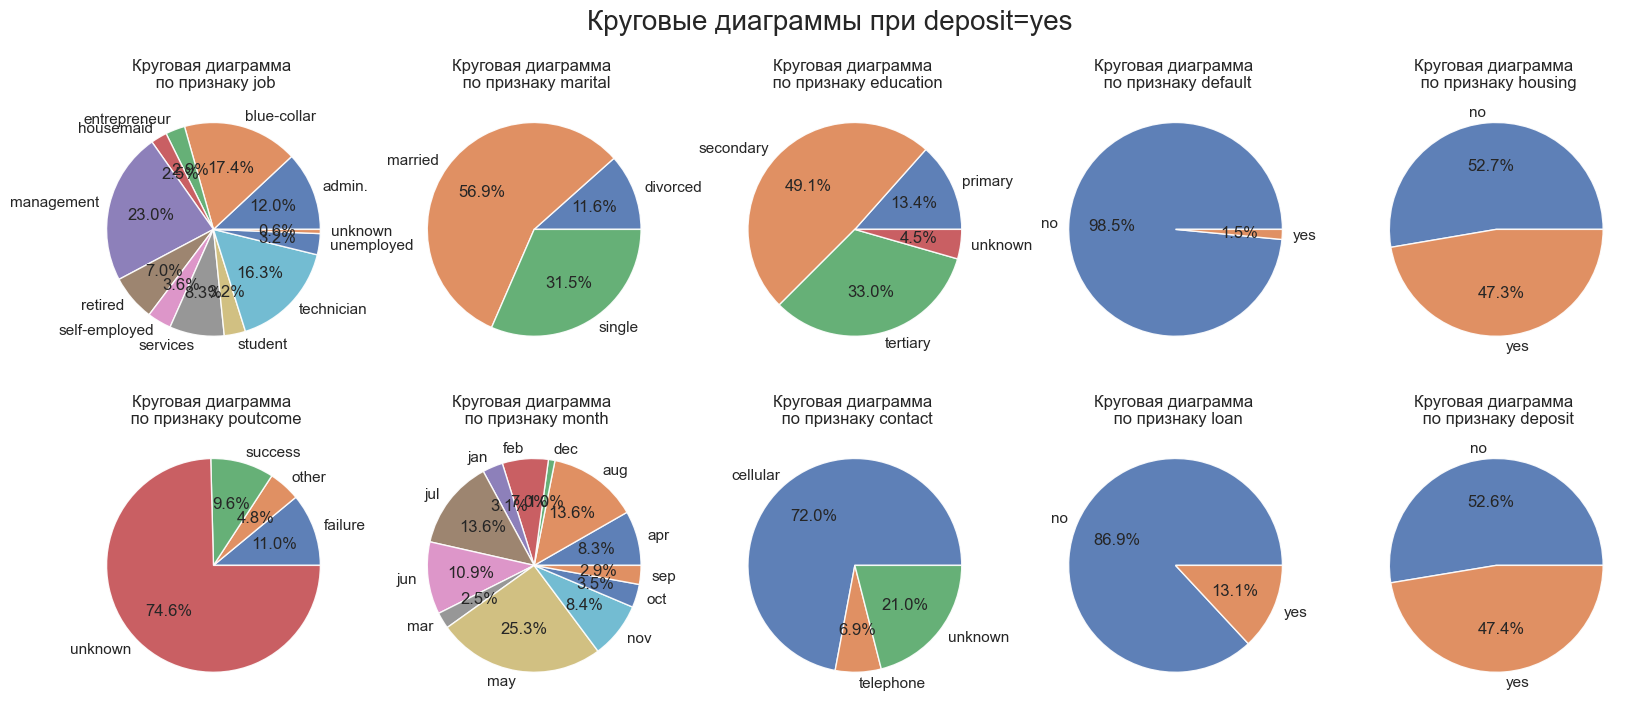

In [13]:
col_names = data.select_dtypes(exclude='number').columns

#построение круговых диаграмм     
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 8))
for i in range(len(col_names)):
    if i==0:
        row=0
        col=i
    elif 0<i<5:
        row=0
        col = i
    else:
        row=1
        col = col-1
        
    data.groupby(col_names[i]).size().plot(kind='pie', subplots=True, figsize=(8, 8), 
                                           autopct='%1.1f%%', ax=axes[row,col], ylabel='', wedgeprops={"alpha": 0.9})
    axes[row,col].set_title(f'Круговая диаграмма \n по признаку {col_names[i]}')  

fig.suptitle('Круговые диаграммы при deposit=yes', fontsize=20)
plt.show()

In [14]:
print('Три наиболее популярных вида работ:', data['job'].value_counts().head(3))

Три наиболее популярных вида работ: job
management     2566
blue-collar    1944
technician     1823
Name: count, dtype: int64


In [15]:
print('Три наиболее популярных месяца последнего контакта:', data['month'].value_counts().head(3))

Три наиболее популярных месяца последнего контакта: month
may    2824
aug    1519
jul    1514
Name: count, dtype: int64


### Корреляционный анализ

Проведем корреляционный анализ признаков в количественной шкале. Сделаем выводы о мультиколлинеарности и при необходимости устраним её.

In [16]:
data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes


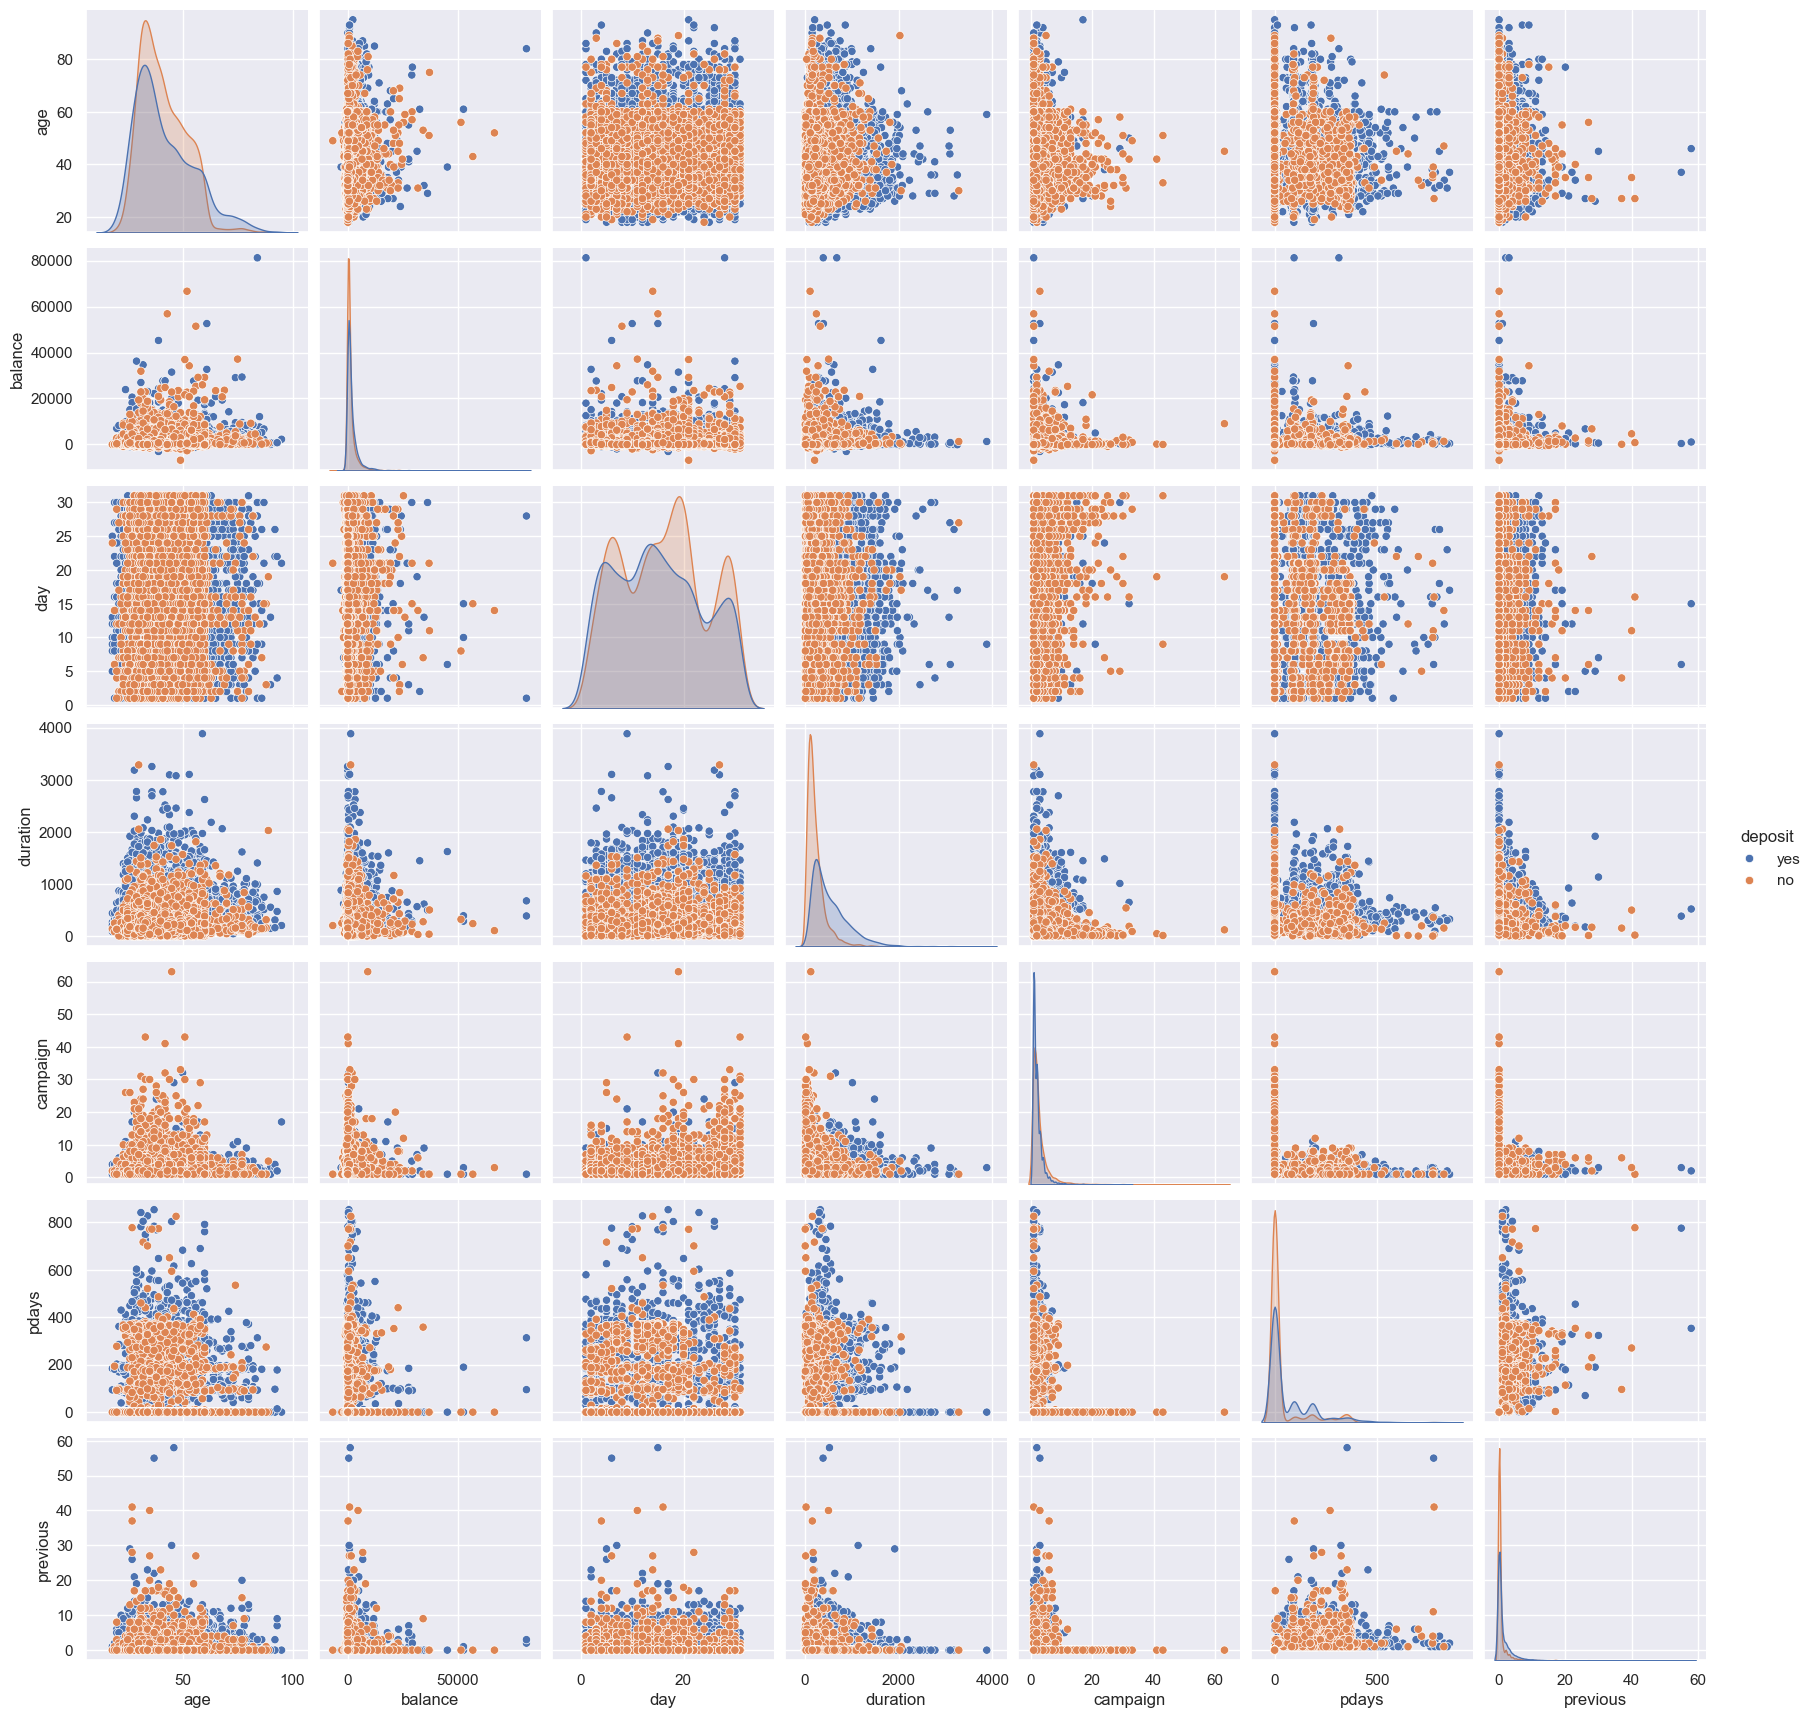

In [17]:
sns.pairplot(data, hue='deposit')
plt.show()

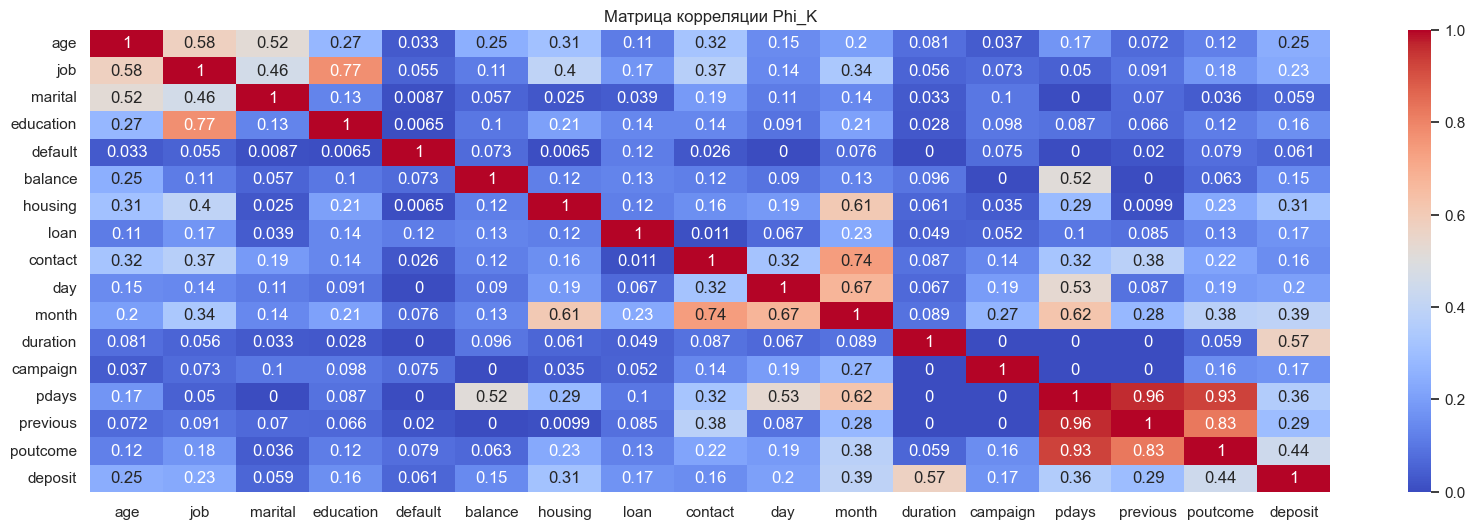

In [18]:
#вычислим корреляции с использованием phik
#при использовании phik настроим параметр interval_cols, передав ему список 
#с названиями непрерывных признаков
corr_matrix = data.phik_matrix(interval_cols=['age','balance','duration'])

#визуализируем матрицы корреляции
plt.figure(figsize=(20, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Матрица корреляции Phi_K')
plt.show()

### Сжатие датасета

Сожмем датасет, приведя его в более экономный тип.

In [19]:
#оптимизация числовых типов данных
def optimize_memory_usage(df: pd.DataFrame, print_size: bool=True) -> pd.DataFrame:
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64'] # Типы, которые будем проверять на оптимизацию
    # Размер занимаемой памяти до оптимизации (в Мб)
    before_size = df.memory_usage().sum() / 1024**2    
    for column in df.columns:
        column_type = df[column].dtypes
        if column_type in numerics:
            column_min = df[column].min()
            column_max = df[column].max()
            if str(column_type).startswith('int'):
                if column_min > np.iinfo(np.int8).min and column_max < np.iinfo(np.int8).max:
                    df[column] = df[column].astype(np.int8)
                elif column_min > np.iinfo(np.int16).min and column_max < np.iinfo(np.int16).max:
                    df[column] = df[column].astype(np.int16)
                elif column_min > np.iinfo(np.int32).min and column_max < np.iinfo(np.int32).max:
                    df[column] = df[column].astype(np.int32)
                elif column_min > np.iinfo(np.int64).min and column_max < np.iinfo(np.int64).max:
                    df[column] = df[column].astype(np.int64)  
            else:
                if column_min > np.finfo(np.float32).min and column_max < np.finfo(np.float32).max:
                    df[column] = df[column].astype(np.float32)
                else:
                    df[column] = df[column].astype(np.float64)    
    # Размер занимаемой памяти после оптимизации (в Мб)
    after_size = df.memory_usage().sum() / 1024**2
    if print_size: print('Размер использования памяти: до {:5.2f} Mb - после {:5.2f} Mb ({:.1f}%)'
                         .format(before_size, after_size, 100 * (before_size - after_size) / before_size))
    return df

In [20]:
data = optimize_memory_usage(data)

Размер использования памяти: до  1.45 Mb - после  0.98 Mb (32.4%)


**Выводы:**
- В данных содержится 11162 записей. Пропуски и дубликаты в данных отсутствуют.
- Анализ количественных переменных показал, что оформление срочного депозита:
  - Практически не зависит от возраста и дня последнего контакта. Средний возраст тех, кто оформляет депозит, и тех, кто не оформляет, практически не отличается и составляет около 41-42 года.
  - Зависит от баланса; длительности последнего контакта в секундах; количества контактов в ходе этой кампании для этого клиента; количества дней, прошедших с момента последнего контакта с клиентом в рамках предыдущей кампании; количества контактов, выполненных до этой кампании и для этого клиента. Баланс оформляющих депозит больше по величине и в среднем составляет 1804, в то время как баланс тех, кто не оформляет, в среднем равен 1280. Количество контактов, выполненных в ходе этой кампании и для клиента, оформившего депозит, в среднем примерно равно 2; не оформившего депозит приближается к 3. Количество дней, прошедших с момента последнего контакта с клиентом в рамках предыдущей кампании, для клиента, оформившего депозит, в среднем составляет около 69; не оформившего депозит в среднем составляет около 36. Количество контактов, выполненных до этой кампании и для этого клиента, для клиента, оформившего депозит, в среднем состалвяет более 1, для не оформившего депозит - менее 1. Таким образом, клиенты, с которыми ранее было больше контактов, являются более лояльными.
- С помощью анализа категориальных переменных установлено, что три наиболее популярных вида работ: management, blue-collar, technician. Три наиболее популярных месяца последнего контакта: may, aug, jul. Семейное положение клиентов: в браке - 56.9%, одинок - 31.5%, разведен - 11.6%. Наличие просроченной задолженности по кредиту присутствует лишь у 1.5%. Жилищный кредит есть практически у половины клиентов (47.3%), в то время как потребительский кредит - лишь у 13.1%. Тип контактной связи в большинстве случаев просходит по сотовому (72.0%). Около половины клиентов (47.4%) оформляет депозит.
- Корреляционный анализ продемонстрировал сильную связь у признаков `previous`, `pdays`, `previous`, так как все эти признаки признаки связаны с количеством контактов.
- Датасет был сжат и приведен в более экономный тип.

## Обучение моделей

Создадим пайплайн, который выберет лучшую комбинацию модели и гиперпараметров. 
Расчитаем метрику ROC-AUC для лучшей модели на тренировочной выборке.

In [21]:
data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes


In [22]:
data.poutcome.unique()

array(['unknown', 'other', 'failure', 'success'], dtype=object)

In [23]:
#разобьем датасет на тренировочную и тестовую выборки
X = data.drop(columns=['duration', 'deposit'], axis=1)
y = data['deposit']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, 
                                                    random_state=RANDOM_STATE)

In [24]:
print('Размер X_train:', X_train.shape)
print('Размер y_train:', y_train.shape)
print('Размер X_test:', X_test.shape)
print('Размер y_test:', y_test.shape)

Размер X_train: (8371, 15)
Размер y_train: (8371,)
Размер X_test: (2791, 15)
Размер y_test: (2791,)


In [25]:
#создадим списки с названиями признаков

# создаём списки с названиями признаков
ohe_columns = ['job', 'marital', 'housing', 'default', 'loan', 'contact', 'month']
ord_columns = ['education', 'poutcome']
num_columns = ['age', 'balance', 'day', 'campaign', 'pdays', 'previous']

In [26]:
#пайплайн для OHE-кодирования признаков из списка ohe_columns
ohe_pipe = Pipeline(
    [('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))]
)

#пайплайн для Ordinal-кодирования признаков из списка ohe_columns пусков
ord_pipe = Pipeline(
    [('ord',  OrdinalEncoder(
                categories=[
                    ['tertiary', 'secondary', 'primary', 'unknown'], 
                    ['success', 'failure', 'other', 'unknown'],
                ], handle_unknown='use_encoded_value', unknown_value=np.nan))])

In [27]:
#общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
)

print(data_preprocessor)

ColumnTransformer(remainder='passthrough',
                  transformers=[('ohe',
                                 Pipeline(steps=[('ohe',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['job', 'marital', 'housing', 'default',
                                  'loan', 'contact', 'month']),
                                ('ord',
                                 Pipeline(steps=[('ord',
                                                  OrdinalEncoder(categories=[['tertiary',
                                                                              'secondary',
                                                                              'primary',
                                                                              'unknown'],
         

In [28]:
#итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

In [29]:
param_grid = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(10, 100),
        'models__min_samples_split': range(10, 100),
        'models__min_samples_leaf': range(10, 100),
        'models__max_features': range(10, 100),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']  
    },
    
    # словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 20),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']   
    },

    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(random_state=RANDOM_STATE, solver='liblinear', penalty='l1')],
        'models__C': range(1, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']  
    },

    # словарь для модели SVC
    {
        'models': [SVC(random_state=RANDOM_STATE, probability= True)],
        'models__kernel': ['linear', 'rbf', 'sigmoid'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']  
    },
    
    # словарь для модели LGBMClassifier
    {
        'models': [LGBMClassifier(random_state=42, n_estimators=70, verbose=-1)],
        'models__num_leaves':range(8, 20),
        'models__max_depth':range(8, 20),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']  
    },
    
    # словарь для модели XGBClassifier
    {
        'models': [XGBClassifier(n_estimators=60, learning_rate= 0.1, scale_pos_weight=2, verbosity = 0)],
        'models__tree_method': ['auto', 'exact', 'approx', 'hist'],
        'models__depth': range(2, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']  
    },
]

In [30]:
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

In [31]:
randomized_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore',
                                                                                                              sparse_output=False))]),
                                                                               ['job',
                                                                                'marital',
                                                                                'housing',
                                                                                'default',
                                                                                'loan',
                                                                                'contact',
                                                                                'month']),
                                                                              ('ord',
                                                                               Pipeline(steps=[('ord',
                                                                                                OrdinalEncoder(categories=[['...
                                                                  min_child_weight=None,
                                                                  missing=nan,
                                                                  monotone_constraints=None,
                                                                  multi_strategy=None,
                                                                  n_estimators=60,
                                                                  n_jobs=None,
                                                                  num_parallel_tree=None,
                                                                  random_state=None, ...)],
                                         'models__depth': range(2, 10),
                                         'models__tree_method': ['auto',
                                                                 'exact',
                                                                 'approx',
                                                                 'hist'],
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               RobustScaler(),
                                                               'passthrough']}],
                   random_state=42, scoring='roc_auc')

In [32]:
print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', randomized_search.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['job', 'marital', 'housing',
                                                   'default', 'loan', 'contact',
                                                   'month']),
                                                 ('ord',
                                                  Pipeline(steps=[('ord',
                                                                   OrdinalEncoder(c

**Выводы:**
- Был создан пайплайн, который выбрал лучшую комбинацию модели для предсказания оформления депозита и гиперпараметров модели по метрике ROC-AUC. Лучшая модель - DecisionTreeClassifier. Метрика ROC-AUC лучшей модели на тренировочной выборке составляет 0.74752.
- Следует отметить, что данное значение ROC-AUC не является идеальным и можно его улучшить, рассмотрев другие более сложные модели.

## Тестирование лучшей модели

Протестируем лучшую модель.

In [33]:
#проверим модель на тестовых данных
y_test_pred = randomized_search.best_estimator_.predict(X_test)
y_test_pred

array(['no', 'no', 'yes', ..., 'no', 'no', 'yes'], dtype=object)

In [34]:
y_pred_proba = randomized_search.best_estimator_.predict_proba(X_test)
y_pred_proba

array([[0.51190476, 0.48809524],
       [0.91780822, 0.08219178],
       [0.45555556, 0.54444444],
       ...,
       [0.7       , 0.3       ],
       [0.58928571, 0.41071429],
       [0.09230769, 0.90769231]])

In [35]:
y_test

5527     no
4541    yes
1964    yes
5007    yes
8928     no
       ... 
5983     no
58      yes
5532     no
9551     no
2291    yes
Name: deposit, Length: 2791, dtype: object

In [36]:
#используем кодировщик для возможности расчета ROC-AUC
encoder = LabelEncoder()
y_pred_encoder = encoder.fit_transform(y_test_pred)
y_test_encoder = encoder.transform(y_test)
encoder.classes_
y_test_encoder

array([0, 1, 1, ..., 0, 0, 1])

In [37]:
roc_auc = roc_auc_score(y_test_encoder, y_pred_proba[:,1])
print ('Метрика ROC-AUC лучшей модели на тестовой выборке:', roc_auc)

Метрика ROC-AUC лучшей модели на тестовой выборке: 0.7614855100414


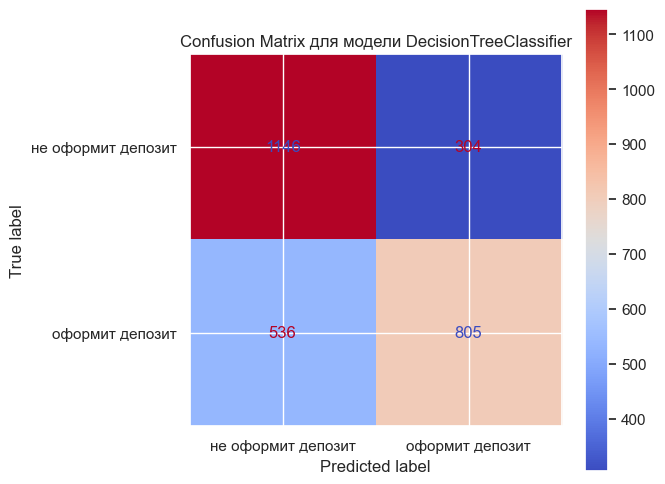

In [38]:
cm_matrix = confusion_matrix(y_test,y_test_pred)

cm_display = ConfusionMatrixDisplay(confusion_matrix = cm_matrix, 
                                    display_labels = ['не оформит депозит','оформит депозит'])

fig, ax = plt.subplots(figsize=(6,6))
cm_display.plot(ax=ax, cmap='coolwarm')
plt.title('Confusion Matrix для модели DecisionTreeClassifier')
plt.show()

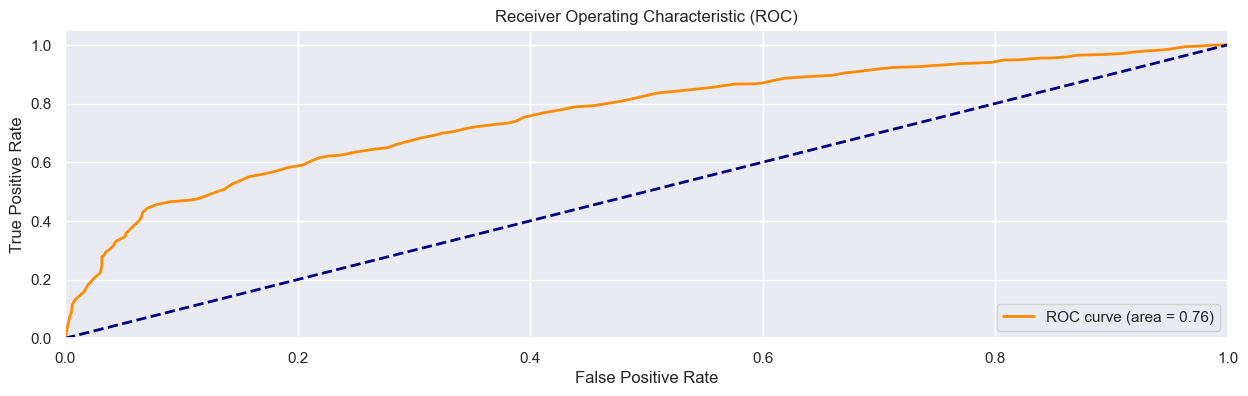

In [39]:
#построение ROC-кривой
fpr, tpr, _ = roc_curve(y_test_encoder, y_pred_proba[:,1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(15, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

In [40]:
results = pd.DataFrame(columns=['Модель','Accuracy','Precision Score','Recall Score','F1-Score','roc_auc'])

model_result = ['DecisionTreeClassifier',accuracy_score(y_test,y_test_pred), 
              precision_score(y_test, y_test_pred, pos_label='yes'), recall_score(y_test, y_test_pred, pos_label='yes'),
              f1_score(y_test, y_test_pred, pos_label='yes'),roc_auc]
results.loc[len(results)]=model_result
results

,Модель,Accuracy,Precision Score,Recall Score,F1-Score,roc_auc
0,DecisionTreeClassifier,0.699033,0.725879,0.600298,0.657143,0.761486


- Лучшая модель DecisionTreeClassifier была проверена на тестовой выборке. Метрика ROC-AUC лучшей модели на тестовой выборке составила 0.76149. Таким образом, выбор модели подтвержден. Для данной модели также была построена Confusion Matrix и определены значения Accuracy, Precision Score, Recall Score, F1-Score.

## Выводы

- В данных содержится 11162 записей. Пропуски и дубликаты в данных отсутствуют.
- Анализ количественных переменных показал, что оформление срочного депозита:
  - Практически не зависит от возраста и дня последнего контакта. Средний возраст тех, кто оформляет депозит, и тех, кто не оформляет, практически не отличается и составляет около 41-42 года.
  - Зависит от баланса; длительности последнего контакта в секундах; количества контактов в ходе этой кампании для этого клиента; количества дней, прошедших с момента последнего контакта с клиентом в рамках предыдущей кампании; количества контактов, выполненных до этой кампании и для этого клиента. Баланс оформляющих депозит больше по величине и в среднем составляет 1804, в то время как баланс тех, кто не оформляет, в среднем равен 1280. Количество контактов, выполненных в ходе этой кампании и для клиента, оформившего депозит, в среднем примерно равно 2; не оформившего депозит приближается к 3. Количество дней, прошедших с момента последнего контакта с клиентом в рамках предыдущей кампании, для клиента, оформившего депозит, в среднем составляет около 69; не оформившего депозит в среднем составляет около 36. Количество контактов, выполненных до этой кампании и для этого клиента, для клиента, оформившего депозит, в среднем состалвяет более 1, для не оформившего депозит - менее 1. Таким образом, клиенты, с которыми ранее было больше контактов, являются более лояльными.
- С помощью анализа категориальных переменных установлено, что три наиболее популярных вида работ: management, blue-collar, technician. Три наиболее популярных месяца последнего контакта: may, aug, jul. Семейное положение клиентов: в браке - 56.9%, одинок - 31.5%, разведен - 11.6%. Наличие просроченной задолженности по кредиту присутствует лишь у 1.5%. Жилищный кредит есть практически у половины клиентов (47.3%), в то время как потребительский кредит - лишь у 13.1%. Тип контактной связи в большинстве случаев просходит по сотовому (72.0%). Около половины клиентов (47.4%) оформляет депозит.
- Корреляционный анализ продемонстрировал сильную связь у признаков `previous`, `pdays`, `previous`, так как все эти признаки признаки связаны с количеством контактов.
- Датасет был сжат и приведен в более экономный тип.
- Был создан пайплайн, который выбрал лучшую комбинацию модели для предсказания оформления депозита и гиперпараметров модели по метрике ROC-AUC. Лучшая модель - DecisionTreeClassifier. Метрика ROC-AUC лучшей модели на тренировочной выборке составляет 0.74752.
- Лучшая модель DecisionTreeClassifier была проверена на тестовой выборке. Метрика ROC-AUC лучшей модели на тестовой выборке составила 0.76149. Таким образом, выбор модели подтвержден. Для данной модели также была построена Confusion Matrix и определены значения Accuracy, Precision Score, Recall Score, F1-Score.